在这个教程中，你将会学到如何使用python的geopandas包创建栅格，对出租车OD数据进行栅格对应，并绘制专题图

<div class="alert alert-info"><h2>提供的基础数据是：</h2><p>
    GIS文件：<br>
    1.深圳行政区划<br>
    <br>
    数据：<br>
    1.出租车OD数据<br></p></div>

[geopandas包的官方document](http://geopandas.org/index.html)

# 读取shp文件

[什么是shapefile(shp)文件](https://baike.baidu.com/item/SHP/7064162?fr=aladdin)

<AxesSubplot:>

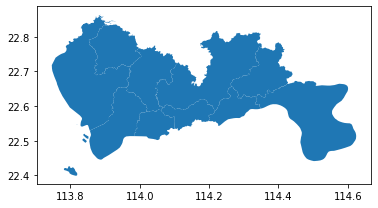

In [1]:
#导入必要的包
import pandas as pd
import numpy as np

#绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt

#geopandas包
import geopandas

#shapely包
from shapely.geometry import Point,Polygon,shape

#读取shapefile文件
shp = r'shapefile/sz.shp'
sz = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')

#绘制看看长什么样
sz.plot()

In [2]:
type(sz)

geopandas.geodataframe.GeoDataFrame

geopandas的格式，就是类似pandas的表格，但是加上一列geometry，记录了每行记录的地理信息

In [3]:
sz.head(5)

,centroid_x,centroid_y,qh,geometry
0,114.143157,22.577605,罗湖,"POLYGON ((114.10006 22.53431, 114.09969 22.535..."
1,114.041535,22.546180,福田,"POLYGON ((113.98578 22.51348, 113.98558 22.523..."
2,114.270206,22.596432,盐田,"POLYGON ((114.22772 22.54290, 114.22643 22.543..."
3,113.851387,22.679120,宝安,"MULTIPOLYGON (((113.81831 22.54676, 113.81816 ..."
4,113.926290,22.766157,光明,"POLYGON ((113.98587 22.80304, 113.98605 22.802..."


每行记录的geometry，它的格式是shapely包的Polygon

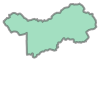

In [4]:
sz['geometry'].iloc[0]

In [5]:
type(sz['geometry'].iloc[0])

shapely.geometry.polygon.Polygon

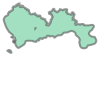

In [6]:
#用unary_union可以将一个geopandas的所有记录合并为一个图形，合并出来的结果是Polygon
sz.unary_union

# 栅格化

我们需要写一个代码，能够直接批量算出来一批经纬度的栅格编号

栅格化的原理
<img src="https://gitee.com/ni1o1/pygeo-tutorial/raw/master/resource/grid.png" style="width:500px">
<img src="https://gitee.com/ni1o1/pygeo-tutorial/raw/master/resource/griddetail.png" style="width:1000px">

In [7]:
#栅格化代码
import math
#定义一个测试栅格划的经纬度
testlon = 114
testlat = 22.5

#划定栅格划分范围
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748

latStart = min(lat1, lat2);
lonStart = min(lon1, lon2);

#定义栅格大小(单位m)
accuracy = 500;

#计算栅格的经纬度增加量大小▲Lon和▲Lat
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360));
deltaLat = accuracy * 360 / (2 * math.pi * 6371004);

#计算栅格的经纬度编号
LONCOL=divmod(float(testlon) - (lonStart - deltaLon / 2) , deltaLon)[0]
LATCOL=divmod(float(testlat) - (latStart - deltaLat / 2) , deltaLat)[0]

#计算栅格的中心点经纬度
HBLON = LONCOL*deltaLon + (lonStart - deltaLon / 2)#格子编号*格子宽+起始横坐标-半个格子宽=格子中心横坐标
HBLAT = LATCOL*deltaLat + (latStart - deltaLat / 2)

#把算好的东西print出来看看
LONCOL,LATCOL,HBLON,HBLAT,deltaLon,deltaLat

(51.0,
 12.0,
 113.99800701150498,
 22.499547959873865,
 0.004872614089207591,
 0.004496605206422906)

▲Lon和▲Lat怎么算的,假设地球是个球：  
<img src="https://gitee.com/ni1o1/pygeo-tutorial/raw/master/resource/jwd.jpg" style="width:500px">

另外，此处LONCOL、LATCOL的计算，我希望起点在第一个格子的中心，因此我减去半个栅格，你也可以希望起点在第一个格子的顶点，但是我们后面的结果没有什么大区别。  
此处没必要纠结，因为你生成了栅格，后面还是要筛掉只保留在shp范围内的格子。  
而我们的初始边界栅格，应该放在shp边界外，也就是说你在纠结的第一个格子在哪没意义，最后还是会把你第一个格子剔除掉。  

另外，我们要生成这些栅格的geopandas数据

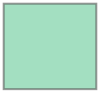

In [8]:
from shapely.geometry import Point,Polygon,shape
Polygon([(HBLON+deltaLon/2,HBLAT-deltaLat/2),
        (HBLON+deltaLon/2,HBLAT+deltaLat/2),
        (HBLON-deltaLon/2,HBLAT+deltaLat/2),
        (HBLON-deltaLon/2,HBLAT-deltaLat/2)])

<AxesSubplot:>

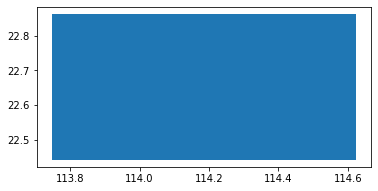

In [9]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point,Polygon,shape


#定义空的geopandas表
data = geopandas.GeoDataFrame()

#定义空的list，后面循环一次就往里面加东西
LONCOL = []
LATCOL = []
geometry = []
HBLON1 = []
HBLAT1 = []

#计算总共要生成多少个栅格
#lon方向是lonsnum个栅格
lonsnum = int((lon2-lon1)/deltaLon)+1
#lat方向是latsnum个栅格
latsnum = int((lat2-lat1)/deltaLat)+1

for i in range(lonsnum):
    for j in range(latsnum):

        HBLON = i*deltaLon + (lonStart - deltaLon / 2)
        HBLAT = j*deltaLat + (latStart - deltaLat / 2)
        #把生成的数据都加入到前面定义的空list里面
        LONCOL.append(i)
        LATCOL.append(j)
        HBLON1.append(HBLON)
        HBLAT1.append(HBLAT)
        
        #生成栅格的Polygon形状
        #这里我们用周围的栅格推算三个顶点的位置，否则生成的栅格因为小数点取值的问题会出现小缝，无法完美覆盖
        HBLON_1 = (i+1)*deltaLon + (lonStart - deltaLon / 2)
        HBLAT_1 = (j+1)*deltaLat + (latStart - deltaLat / 2)
        geometry.append(Polygon([
        (HBLON-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT_1-deltaLat/2),
        (HBLON-deltaLon/2,HBLAT_1-deltaLat/2)]))
        
#为geopandas文件的每一列赋值为刚刚的list
data['LONCOL'] = LONCOL
data['LATCOL'] = LATCOL
data['HBLON'] = HBLON1
data['HBLAT'] = HBLAT1
data['geometry'] = geometry

data.plot()
# geometry
# LONCOL

注：如果打开了seaborn(另一绘图包)，即使数据相同，绘制出来的图也可能会有差异。

In [10]:
# 可以查看对应方法的作用及参数
# ?data.intersects
data.head(5)

,LONCOL,LATCOL,HBLON,HBLAT,geometry
0,0,0,113.749504,22.445589,"POLYGON ((113.74707 22.44334, 113.75194 22.443..."
1,0,1,113.749504,22.450085,"POLYGON ((113.74707 22.44784, 113.75194 22.447..."
2,0,2,113.749504,22.454582,"POLYGON ((113.74707 22.45233, 113.75194 22.452..."
3,0,3,113.749504,22.459079,"POLYGON ((113.74707 22.45683, 113.75194 22.456..."
4,0,4,113.749504,22.463575,"POLYGON ((113.74707 22.46133, 113.75194 22.461..."


取栅格和深圳行政区划的交集栅格

<AxesSubplot:>

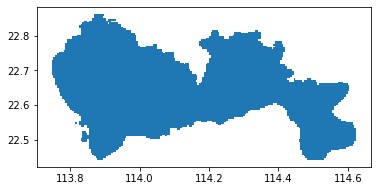

In [11]:
grid = data[data.intersects(sz.unary_union)]
grid.plot()

In [12]:
#保存
grid.to_file(r'shapefile\grid',encoding = 'utf-8')

# 将数据对应到栅格

提示：我们上一步已经把testlon和testlat实现了栅格化，那么如何让出租车的OD数据全部都栅格化呢？（请不要用到循环语句，循环遍历计算效率非常低）

    在上一个教程里，我们已经从出租车的原始数据中提取到了OD，保存在了
    data-sample/TaxiOD.csv
    现在我们继续

In [13]:
import pandas as pd
TaxiOD = pd.read_csv(r'data-sample/TaxiOD.csv')
TaxiOD.columns = ['VehicleNum', 'Stime', 'SLng', 'SLat', 
       'ELng', 'ELat','Etime']
TaxiOD.head(5)

,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17


In [14]:

###############################你需要在下面写代码##################################
#计算起点栅格的经纬度编号
#TaxiOD['SLONCOL'] = 
#TaxiOD['SLATCOL'] = 

#计算起点栅格的中心点经纬度
#TaxiOD['SHBLON'] = 
#TaxiOD['SHBLAT'] = 

#计算终点栅格的经纬度编号
#TaxiOD['ELONCOL'] = 
#TaxiOD['ELATCOL'] = 

#计算终点栅格的中心点经纬度
#TaxiOD['EHBLON'] = 
#TaxiOD['EHBLAT'] = 

#筛选去掉起点终点在同一个格子里的OD
#筛选去掉不在研究范围内的栅格，TaxiOD的LONCOL、LATCOL都需要在我们的范围内


###################################################################################

TaxiOD.head(5)

,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17


In [15]:
###############################     答    案    ##################################

TaxiOD = TaxiOD[-TaxiOD['ELng'].isnull()].copy()
TaxiOD['SLONCOL'] = ((TaxiOD['SLng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['SLATCOL'] = ((TaxiOD['SLat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
TaxiOD['SHBLON'] = TaxiOD['SLONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['SHBLAT'] = TaxiOD['SLATCOL']*deltaLat + (latStart - deltaLat / 2)
TaxiOD['ELONCOL'] = ((TaxiOD['ELng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['ELATCOL'] = ((TaxiOD['ELat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
TaxiOD['EHBLON'] = TaxiOD['ELONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['EHBLAT'] = TaxiOD['ELATCOL']*deltaLat + (latStart - deltaLat / 2)
#筛选去掉起点终点在同一个格子里的OD
TaxiOD = TaxiOD[-((TaxiOD['SLONCOL']==TaxiOD['ELONCOL'])&(TaxiOD['SLATCOL']==TaxiOD['ELATCOL']))]
#筛选去掉不在研究范围内的栅格
TaxiOD = TaxiOD[(TaxiOD['SLONCOL']>=0) & (TaxiOD['SLATCOL']>=0) &(TaxiOD['ELONCOL']>=0) & (TaxiOD['ELATCOL']>=0)&
(TaxiOD['SLONCOL']<=lonsnum) & (TaxiOD['SLATCOL']<=latsnum) &(TaxiOD['ELONCOL']<=lonsnum) & (TaxiOD['ELATCOL']<=latsnum)]
###################################################################################
TaxiOD.head(5)

,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime,SLONCOL,SLATCOL,SHBLON,SHBLAT,ELONCOL,ELATCOL,EHBLON,EHBLAT
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48,85,25,114.163676,22.558004,97,23,114.222147,22.549011
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19,98,24,114.227020,22.553507,98,25,114.227020,22.558004
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06,98,25,114.227020,22.558004,103,32,114.251383,22.589480
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42,100,26,114.236765,22.562500,76,26,114.119822,22.562500
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17,79,28,114.134440,22.571494,85,36,114.163676,22.607466


In [19]:
OD = TaxiOD.groupby(['SLONCOL','SLATCOL','ELONCOL','ELATCOL'])['VehicleNum'].count().reset_index()

In [20]:
OD['SHBLON'] = OD['SLONCOL'] * deltaLon + (lonStart - deltaLon / 2)
OD['SHBLAT'] = OD['SLATCOL'] * deltaLat + (latStart - deltaLat / 2)
OD['EHBLON'] = OD['ELONCOL'] * deltaLon + (lonStart - deltaLon / 2)
OD['EHBLAT'] = OD['ELATCOL'] * deltaLat + (latStart - deltaLat / 2)
OD

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum,SHBLON,SHBLAT,EHBLON,EHBLAT
0,0,72,33,20,1,113.749504,22.769344,113.910300,22.535521
1,0,75,14,70,1,113.749504,22.782834,113.817720,22.760351
2,0,81,19,64,1,113.749504,22.809814,113.842083,22.733371
3,1,74,10,75,1,113.754376,22.778337,113.798230,22.782834
4,1,77,5,78,1,113.754376,22.791827,113.773867,22.796324
...,...,...,...,...,...,...,...,...,...
193450,155,33,75,22,1,114.504759,22.593977,114.114950,22.544514
193451,156,66,153,66,1,114.509631,22.742365,114.495014,22.742365
193452,160,65,157,66,1,114.529122,22.737868,114.514504,22.742365
193453,161,10,150,27,1,114.533995,22.490555,114.480396,22.566997


# 集计栅格OD（全天、高峰时段）

提示：需要用到pandasdataframe的方法df.groupby，百度一下，或者<a href="http://pandas.pydata.org/pandas-docs/stable/">戳这里是pandas的document</a>

In [21]:
#集计OD
###############################你需要在下面写代码##################################
#提示：用df.groupby().count()计数

#groupby的列都会变成index，所以我们用.reset_index()，将index重新变成列

###################################################################################

#OD按大小排序
OD = OD.sort_values(by = 'VehicleNum',ascending = False)

In [23]:
###############################     答    案    ##################################

#这个是对每一列都计数了，所以取其中一列出来，例如我这里取了['VehicleNum']
OD= TaxiOD.groupby(['SLONCOL','SLATCOL','ELONCOL','ELATCOL'])['VehicleNum'].count().reset_index()

###################################################################################
OD

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum
0,0,72,33,20,1
1,0,75,14,70,1
2,0,81,19,64,1
3,1,74,10,75,1
4,1,77,5,78,1
...,...,...,...,...,...
193450,155,33,75,22,1
193451,156,66,153,66,1
193452,160,65,157,66,1
193453,161,10,150,27,1


注意：VehicleNum变量在这里groupby了以后，这个字段就变成了计数count数量，不再是车牌号了

# 绘制栅格的OD图

## 绘制前20的OD

In [40]:
#取前20的OD
Topod = OD.iloc[:50].copy()

#计算起点栅格的中心点经纬度
Topod['SHBLON'] = Topod['SLONCOL'] * deltaLon + (lonStart - deltaLon / 2)
Topod['SHBLAT'] = Topod['SLATCOL'] * deltaLat + (latStart - deltaLat / 2)

#计算终点栅格的中心点经纬度
Topod['EHBLON'] = Topod['ELONCOL'] * deltaLon + (lonStart - deltaLon / 2)
Topod['EHBLAT'] = Topod['ELATCOL'] * deltaLat + (latStart - deltaLat / 2)

In [41]:
#导入绘图包
import matplotlib as mpl
import matplotlib.pyplot as plt

注：此处若出现错误
>index 4 is out of bounds for size 4

原因是你的geopandas版本低不支持rgba，两种解决方法：
>1.改用颜色代码，把edgecolor和facecolor的值换成颜色代码#ffffff  
2.升级geopandas，在cmd里pip install -U -user geopandas

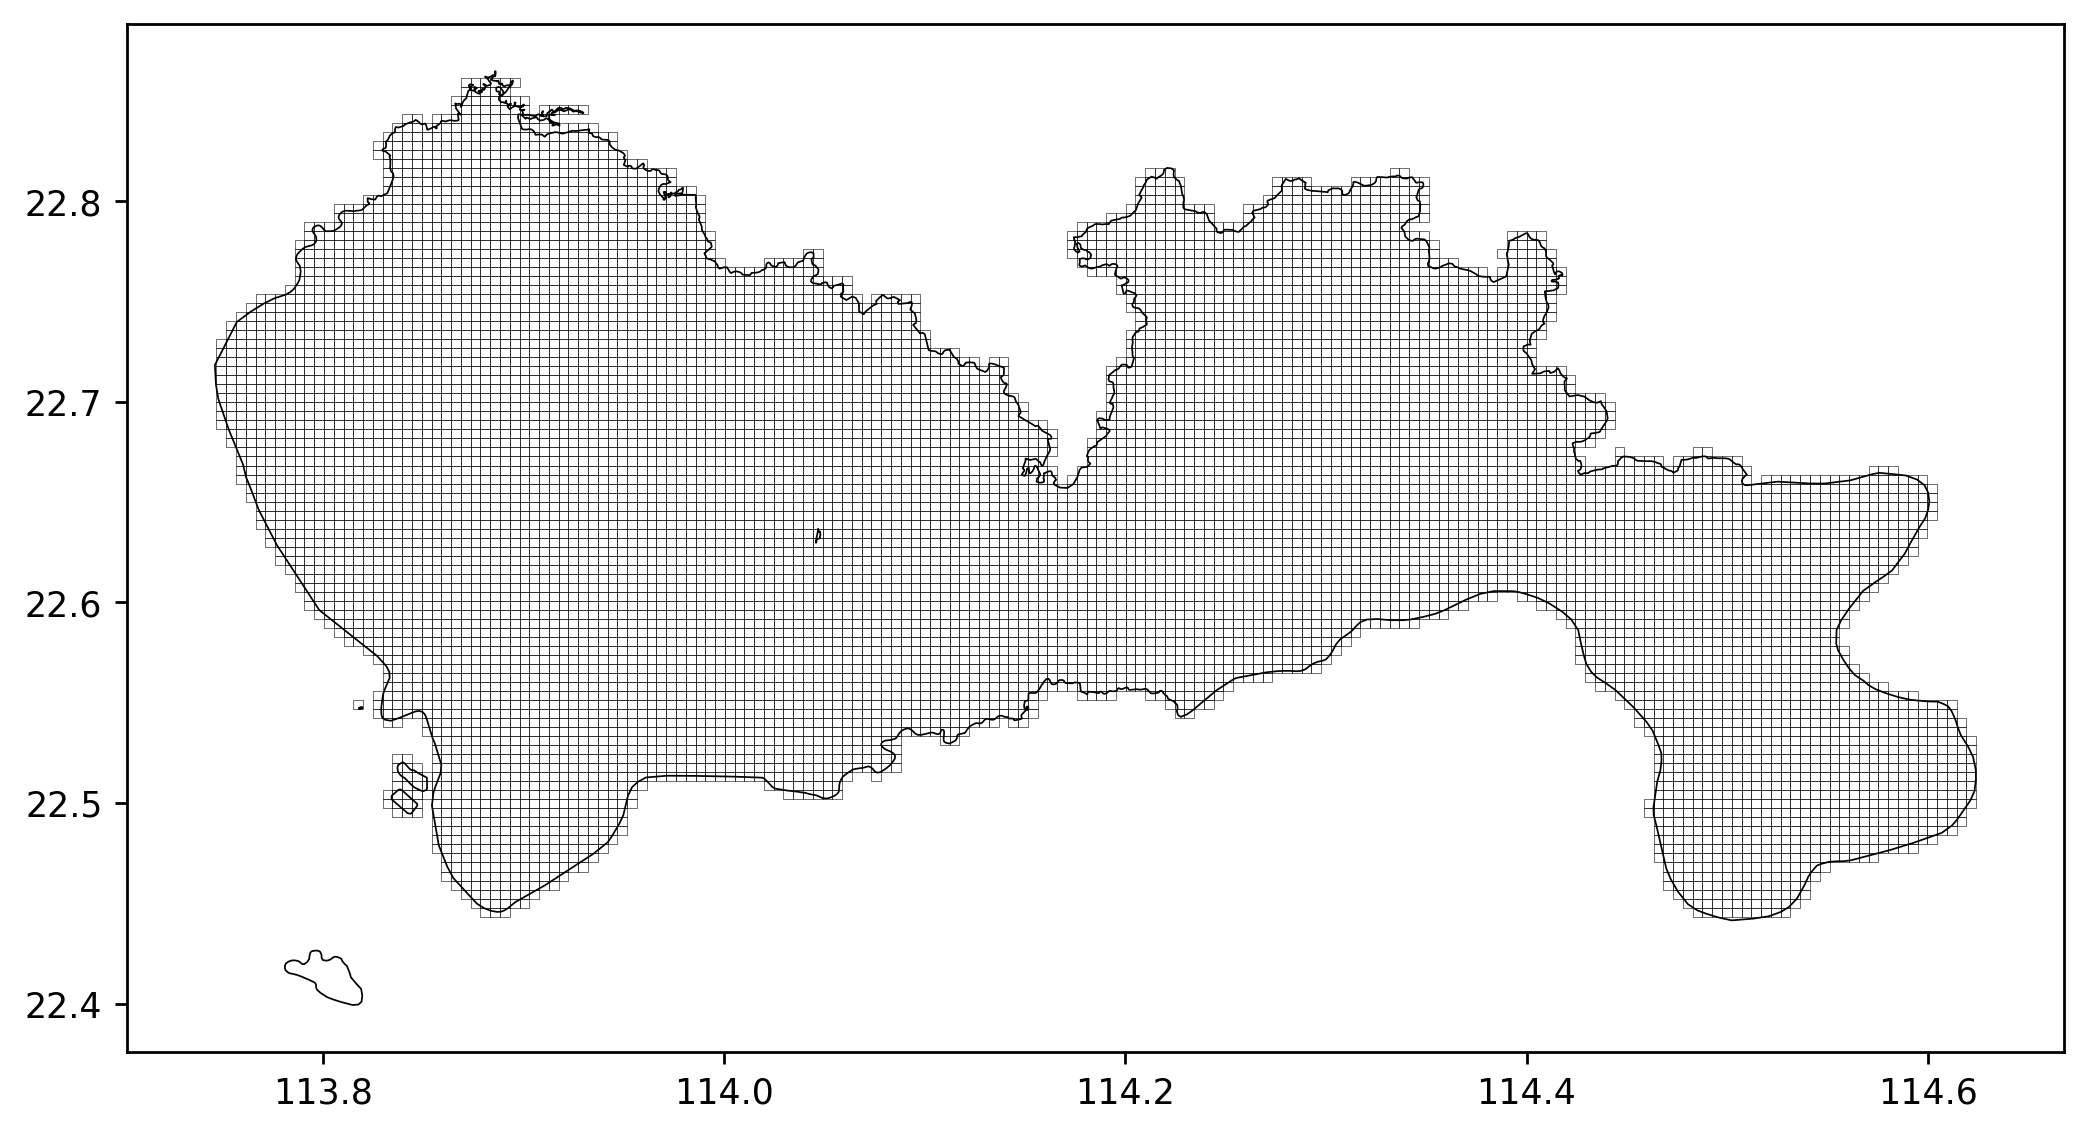

In [42]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#把刚才生成的栅格在ax上绘制
grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)

#把合并的行政区划变成一个geopandas，在ax上绘制
SZ_all = geopandas.GeoDataFrame()
SZ_all['geometry'] = [sz.unary_union]
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

plt.show()

In [ ]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#把刚才生成的栅格在ax上绘制
grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)

#绘制整个深圳的范围
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

for i in range(len(Topod)):

    #首先获取OD的经纬度
    #然后用plt.plot()绘制,设定linewidth和color都为固定值
############################你需要在下面写代码############################

    

##################################################################################
#不显示坐标轴
# plt.axis('off')

# plt.show()

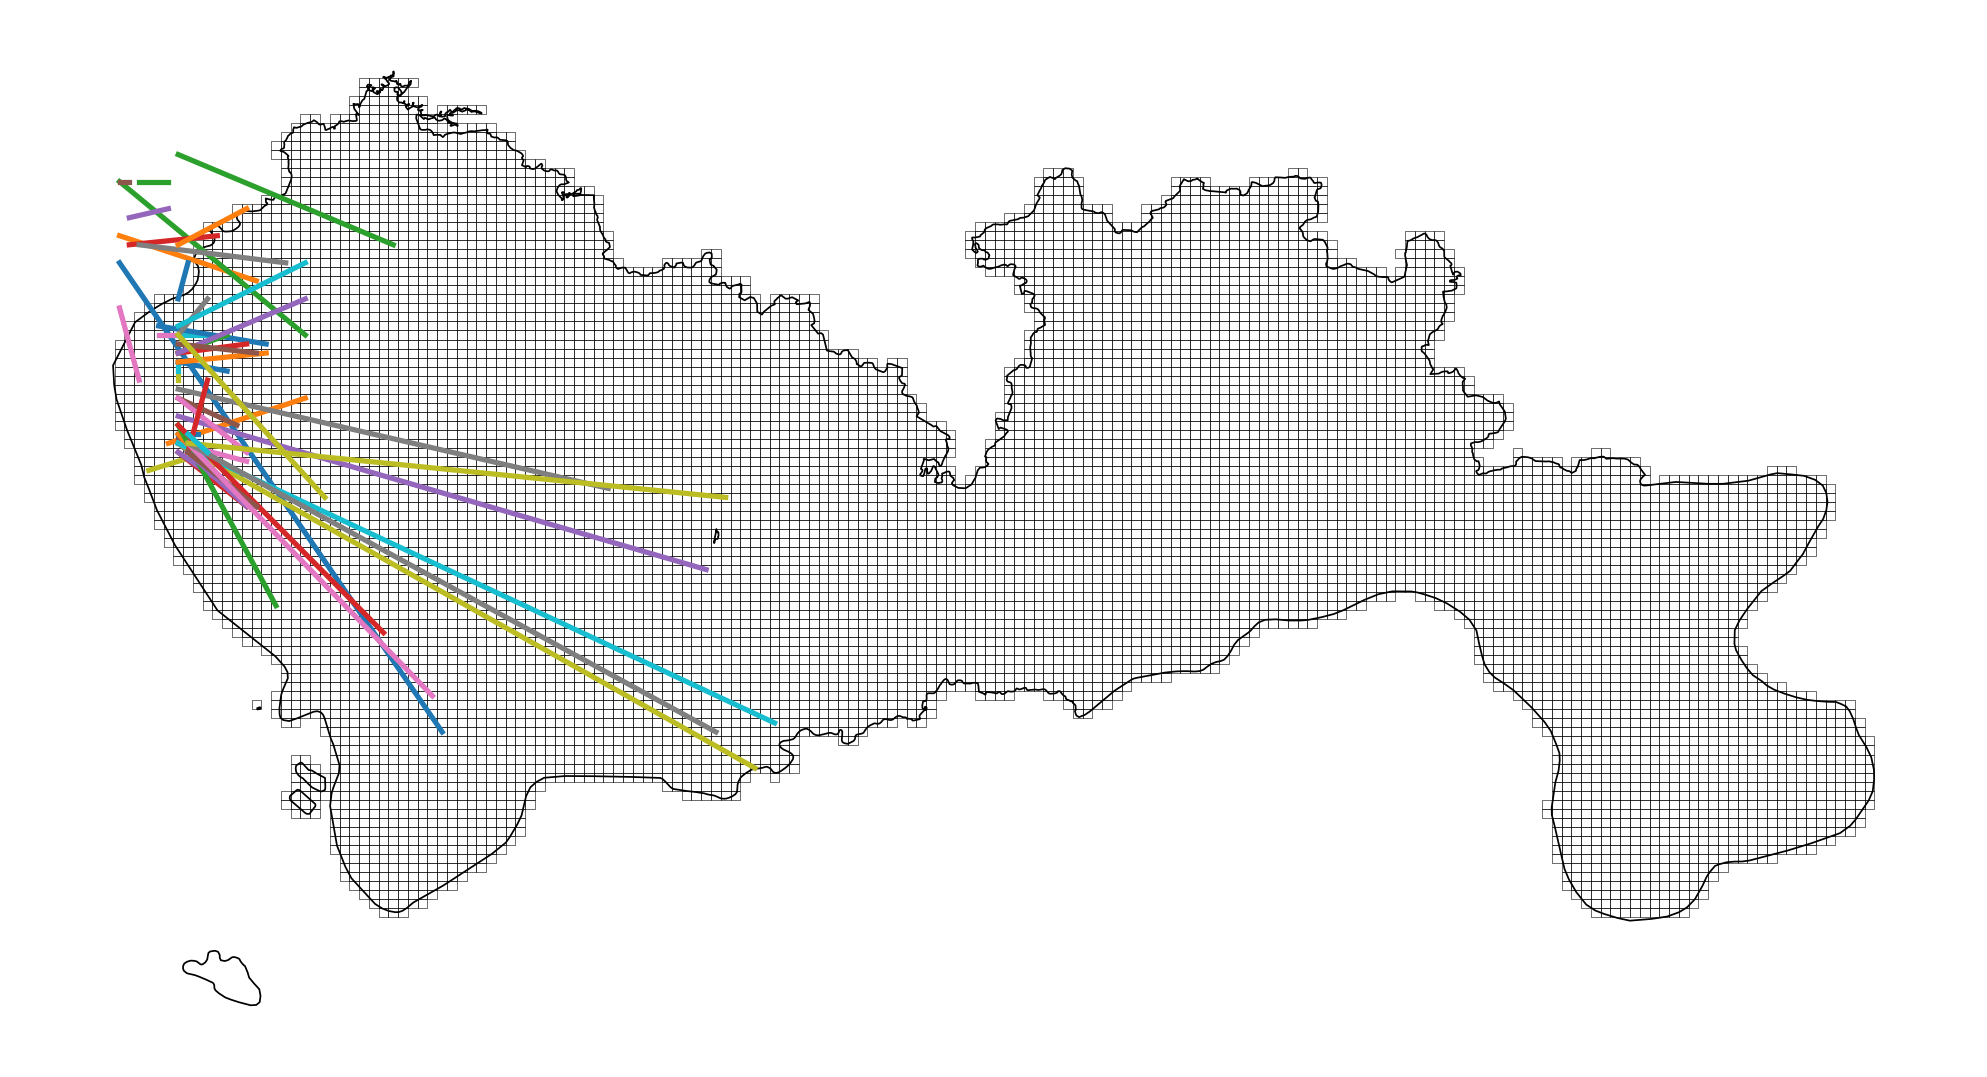

In [44]:
###############################     答案   ##################################
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

for i in range(len(Topod)):

    
    plt.plot([Topod['SHBLON'].iloc[i],Topod['EHBLON'].iloc[i]],[Topod['SHBLAT'].iloc[i],Topod['EHBLAT'].iloc[i]])


#不显示坐标轴
plt.axis('off')

plt.show()
##################################################################################

## 绘制全部的OD

我们还是把多一点OD画出来吧，这个时候我们要用OD的粗细，颜色深度，和透明度，来表示OD量大小

In [45]:
OD1 = OD[OD['VehicleNum']>10].copy()

#OD从小到大排序方便我们后续操作，因为我们希望小的OD先画，放在最底下，大的OD后画，放在最上面
OD1 = OD1.sort_values(by = 'VehicleNum')

#计算起点栅格的中心点经纬度
OD1['SHBLON'] = OD1['SLONCOL'] * deltaLon + (lonStart - deltaLon / 2)
OD1['SHBLAT'] = OD1['SLATCOL'] * deltaLat + (latStart - deltaLat / 2)

#计算终点栅格的中心点经纬度
OD1['EHBLON'] = OD1['ELONCOL'] * deltaLon + (lonStart - deltaLon / 2)
OD1['EHBLAT'] = OD1['ELATCOL'] * deltaLat + (latStart - deltaLat / 2)

#对OD分5组，生成一个取值为0-1的列，每组的值相同，用以表示OD的粗细，取名linewidth
step = 5
OD1['linewidth'] = (np.array(range(len(OD1)))*step/len(OD1)).astype('int')/step+0.1
OD1.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum,SHBLON,SHBLAT,EHBLON,EHBLAT,linewidth
960,12,40,12,39,11,113.807975,22.625453,113.807975,22.620956,0.1
104714,61,22,58,21,11,114.046733,22.544514,114.032115,22.540017,0.1
104605,61,22,12,40,11,114.046733,22.544514,113.807975,22.625453,0.1
104446,61,21,64,16,11,114.046733,22.540017,114.061351,22.517534,0.1
104400,61,21,61,17,11,114.046733,22.540017,114.046733,22.522031,0.1


绘制OD用时 31.63205885887146 秒


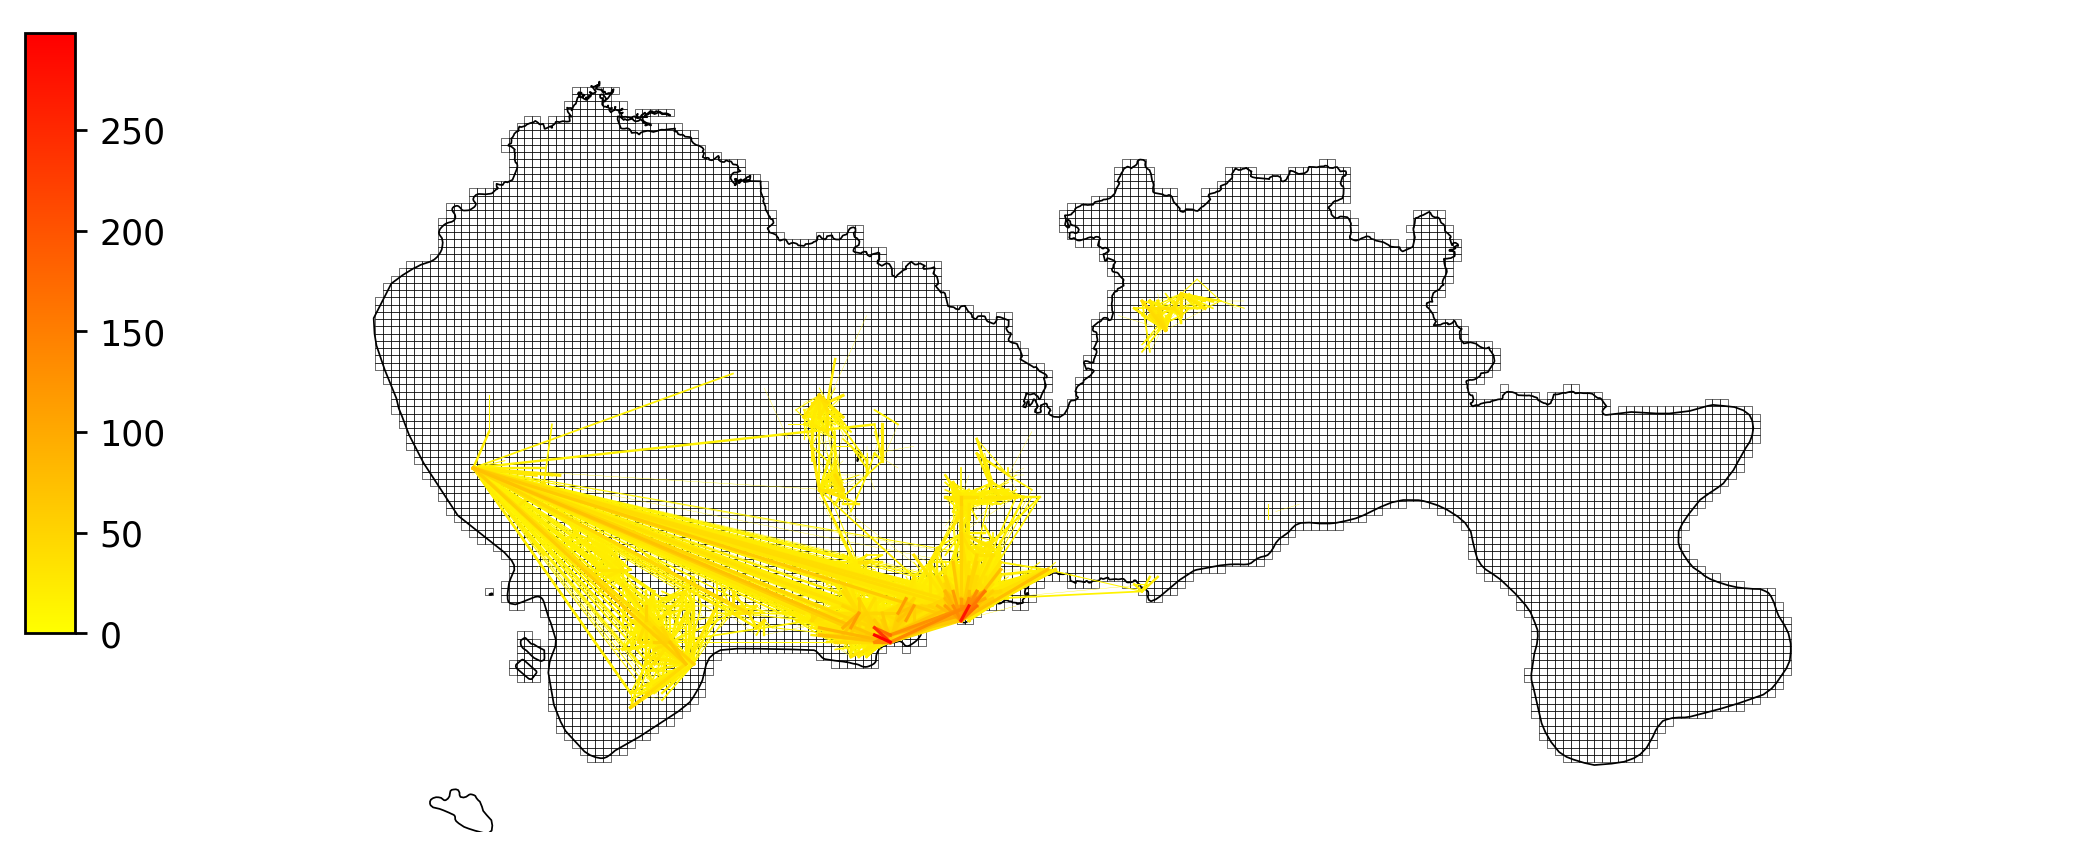

In [37]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#把刚才生成的栅格在ax上绘制
grid.plot(ax = ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)

#绘制整个深圳的范围
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

#设置colormap的数据
import matplotlib
vmax = OD['VehicleNum'].max()
#设定一个标准化的工具，设定OD的colormap最大最小值，他的作用是norm(count)就会将count标准化到0-1的范围内
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
#设定colormap的颜色
cmapname = 'autumn_r'
#cmap是一个获取颜色的工具，cmap(a)会返回颜色，其中a是0-1之间的值
cmap = matplotlib.cm.get_cmap(cmapname)

#绘制OD
timeflag = time.time()
for i in range(len(OD1)):
    ###########################你需要在下面写代码#############################
    #设定plt.plot里面的参数alpha和color和linewidth
    
    
    ###################################################################################
print('绘制OD用时',time.time()-timeflag,'秒')
    
#不显示坐标轴
plt.axis('off')    

#绘制假的colorbar，这是因为，我们画的OD是线，没办法直接画出来colorbar
#所以我们在一个看不见的地方画了一个叫imshow的东西，他的范围是0到vmax
#然后我们再对imshow添加colorbar
plt.imshow([[0,vmax]], cmap=cmap)
#设定colorbar的大小和位置
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)

#然后要把镜头调整回到深圳地图那，不然镜头就在imshow那里了


ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)



plt.show()

## 更快的绘制方法

如果遍历绘制OD，绘制速度比较慢，绘制5319条OD用时31s。  
但是，如果把DataFrame变成GeoDataFrame，然后用自带的plot函数绘制，会快很多

In [40]:
#生成geometry
###########################你需要在下面写代码#############################
#把DataFrame变成GeoDataFrame
#对每一行生成线的geometry

###################################################################################


OD1.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum,SHBLON,SHBLAT,EHBLON,EHBLAT,linewidth,geometry
45739,39,23,39,13,11,113.939536,22.549011,113.939536,22.504045,0.1,"LINESTRING (113.93954 22.54901, 113.93954 22.5..."
1846,12,40,62,19,11,113.807975,22.625453,114.051606,22.531024,0.1,"LINESTRING (113.80798 22.62545, 114.05161 22.5..."
152500,74,33,75,35,11,114.110077,22.593977,114.114950,22.602970,0.1,"LINESTRING (114.11008 22.59398, 114.11495 22.6..."
1851,12,40,62,27,11,113.807975,22.625453,114.051606,22.566997,0.1,"LINESTRING (113.80798 22.62545, 114.05161 22.5..."
105943,61,27,61,20,11,114.046733,22.566997,114.046733,22.535521,0.1,"LINESTRING (114.04673 22.56700, 114.04673 22.5..."


In [46]:
###############################     答案   ##################################

from shapely.geometry import LineString
# 线生成器（重要）
OD1['geometry'] = OD1.apply(lambda r:LineString([[r['SHBLON'],r['SHBLAT']],[r['EHBLON'],r['EHBLAT']]]),axis = 1)
OD1 = geopandas.GeoDataFrame(OD1)
###################################################################################


d:\python\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


绘制底图用时 1.6689996719360352 秒
绘制OD用时 0.35900139808654785 秒


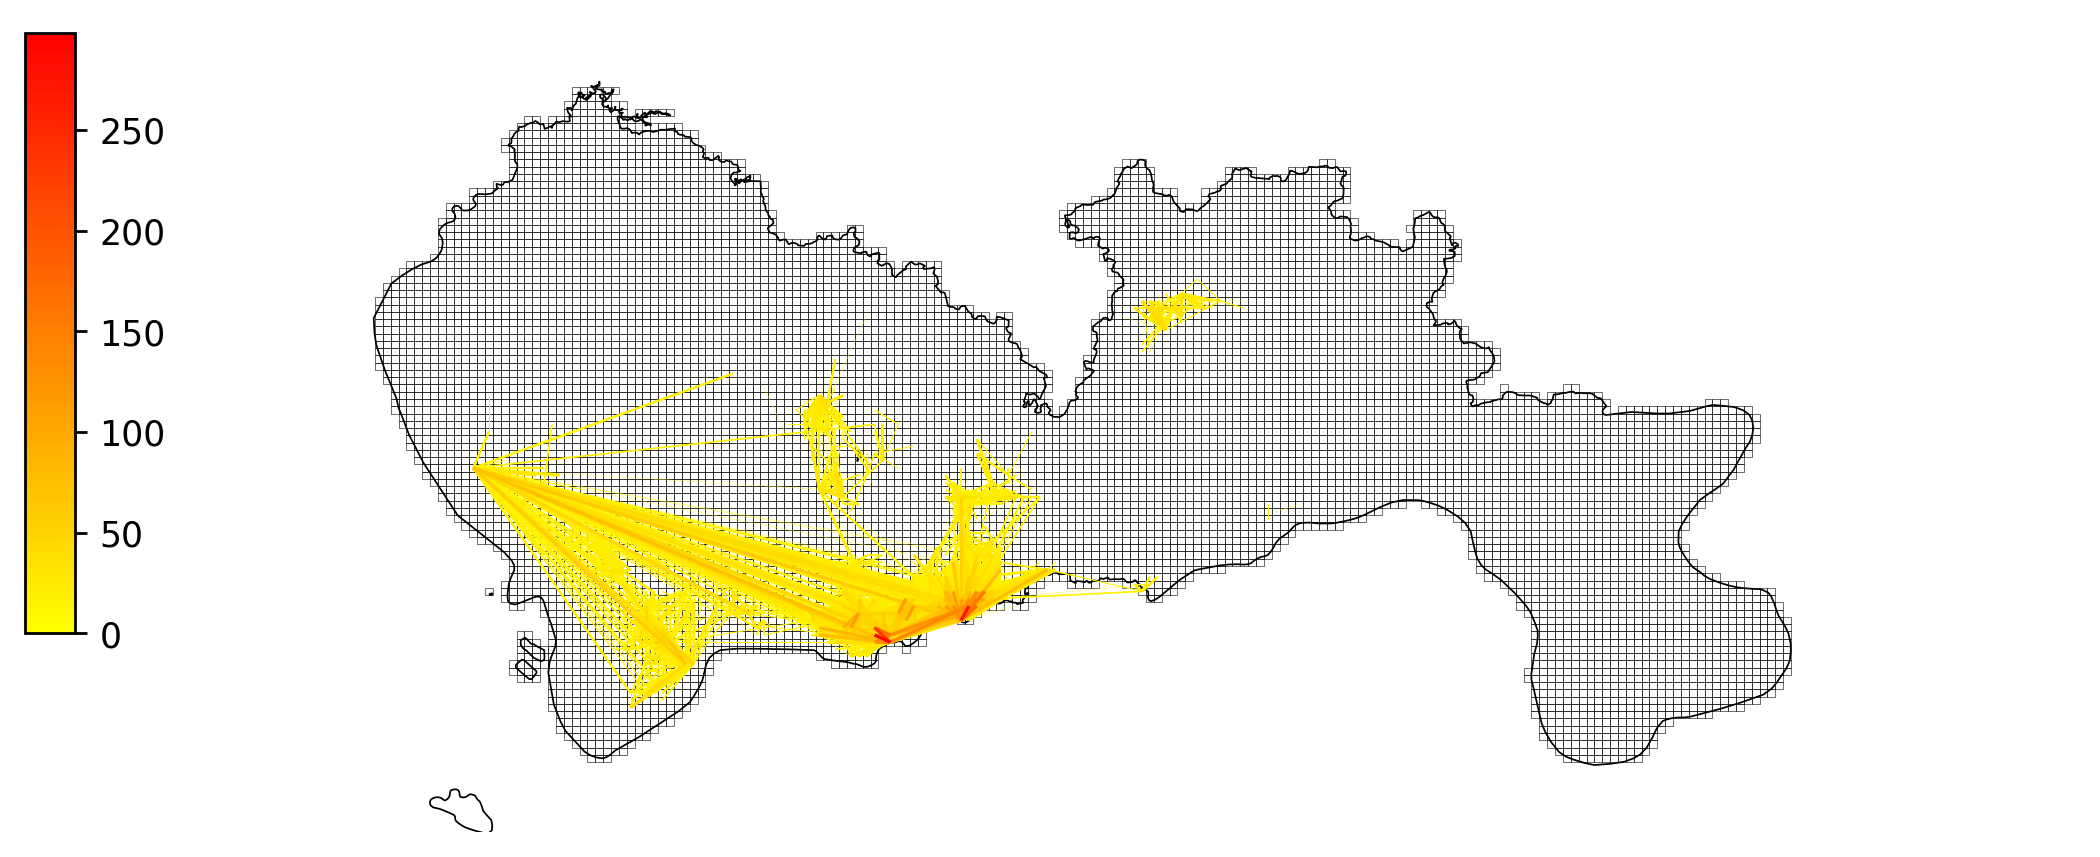

In [47]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#计时
import time
timeflag = time.time()
#绘制底图
grid.plot(ax = ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)
print('绘制底图用时',time.time()-timeflag,'秒')


#设置colormap的数据
import matplotlib
vmax = OD['VehicleNum'].max()
cmapname = 'autumn_r'
cmap = matplotlib.cm.get_cmap(cmapname)

timeflag = time.time()
#绘制OD
OD1.plot(ax = ax,column = 'VehicleNum',vmax = vmax,vmin = 0,cmap = cmap,linewidth = OD1['linewidth'])
print('绘制OD用时',time.time()-timeflag,'秒')

plt.axis('off')    
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)
plt.show()

遍历绘制需要30秒，GeoDataFrame绘制只需要0.3秒，而且绘制效果完全相同！

# 绘制栅格专题图

绘制起点的分布图

In [48]:
#集计
Odistribution = OD.groupby(['SLONCOL','SLATCOL'])['VehicleNum'].sum().reset_index()

In [49]:
#将集计的结果与栅格的geopandas执行merge操作
gridtoplot = pd.merge(grid,Odistribution.rename(columns = {'SLONCOL':'LONCOL','SLATCOL':'LATCOL'}),on = ['LONCOL','LATCOL'])
gridtoplot = gridtoplot.rename(columns = {'VehicleNum':'count'})

In [50]:
gridtoplot

,LONCOL,LATCOL,HBLON,HBLAT,geometry,count
0,2,59,113.759249,22.710888,"POLYGON ((113.75681 22.70864, 113.76169 22.708...",1
1,3,49,113.764122,22.665922,"POLYGON ((113.76169 22.66367, 113.76656 22.663...",1
2,4,64,113.768994,22.733371,"POLYGON ((113.76656 22.73112, 113.77143 22.731...",1
3,4,65,113.768994,22.737868,"POLYGON ((113.76656 22.73562, 113.77143 22.735...",1
4,5,52,113.773867,22.679412,"POLYGON ((113.77143 22.67716, 113.77630 22.677...",1
...,...,...,...,...,...,...
3207,149,23,114.475523,22.549011,"POLYGON ((114.47309 22.54676, 114.47796 22.546...",1
3208,150,26,114.480396,22.562500,"POLYGON ((114.47796 22.56025, 114.48283 22.560...",1
3209,155,33,114.504759,22.593977,"POLYGON ((114.50232 22.59173, 114.50720 22.591...",1
3210,161,10,114.533995,22.490555,"POLYGON ((114.53156 22.48831, 114.53643 22.488...",1


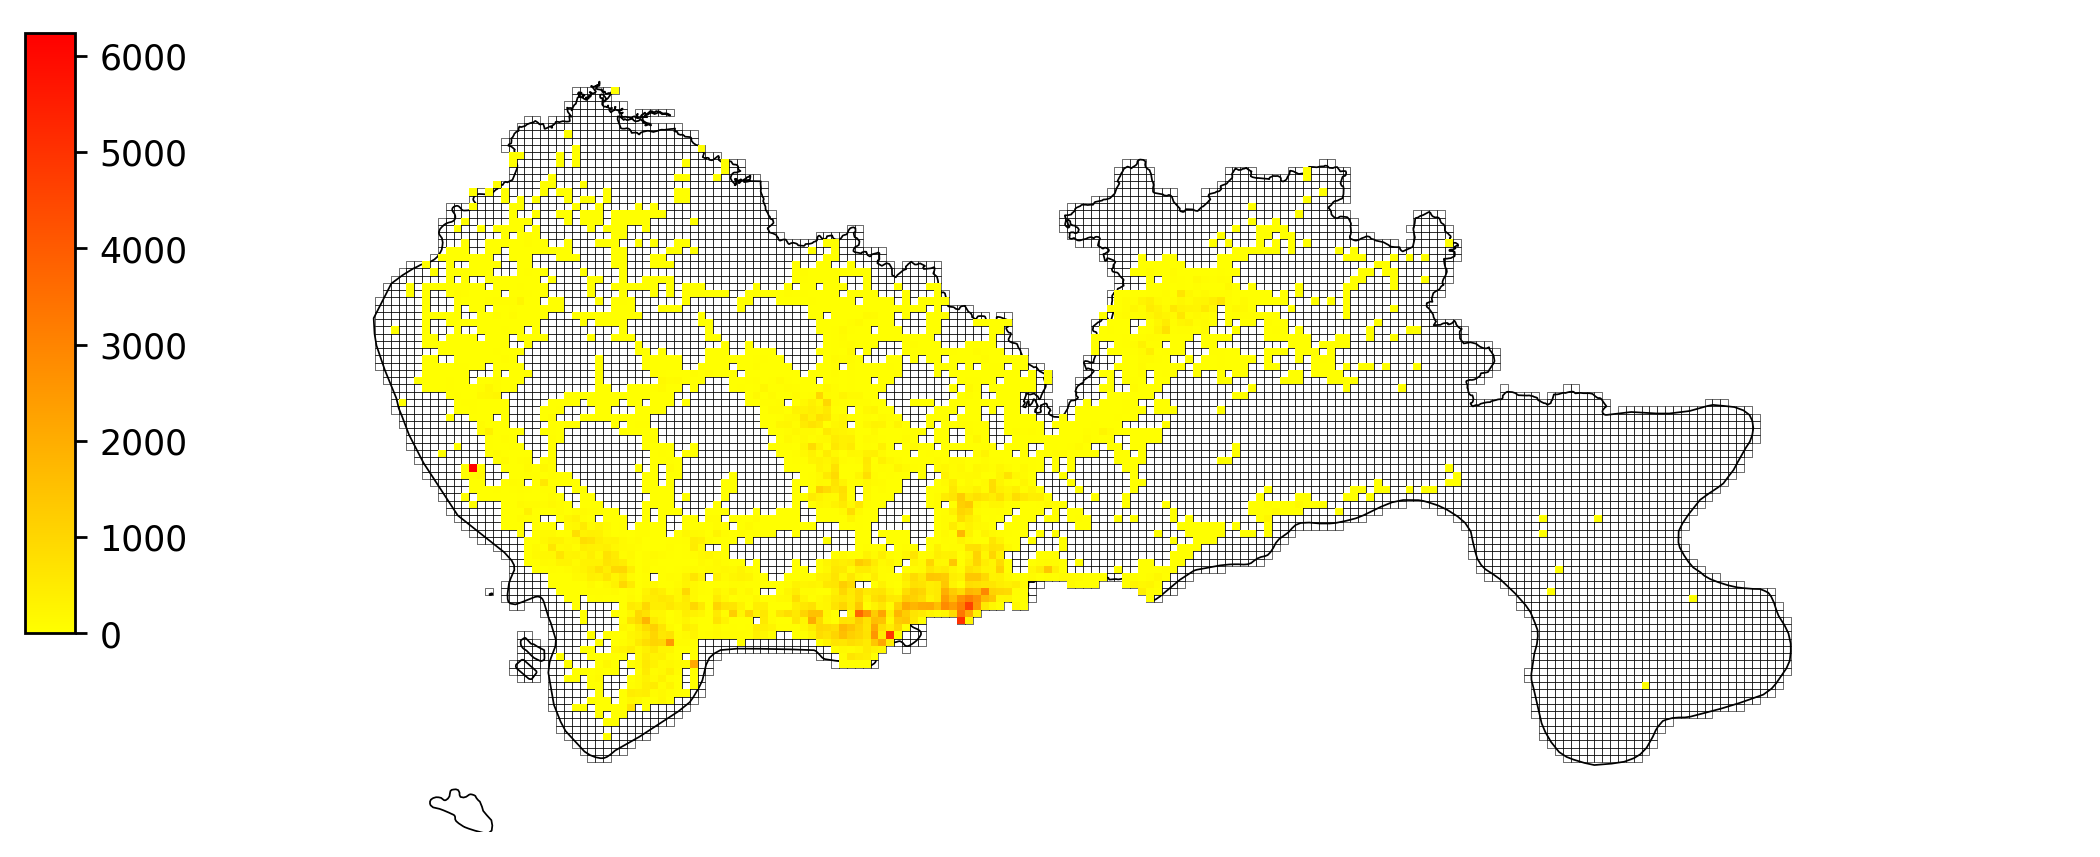

In [52]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)
grid.plot(ax = ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidth = 0.2)
SZ_all = geopandas.GeoDataFrame()
SZ_all['geometry'] = [sz.unary_union]
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

vmax = gridtoplot['count'].max()
gridtoplot.plot(ax = ax,column = 'count',vmax = vmax, vmin = 0,cmap = cmap)

plt.axis('off')

ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.imshow([[0,vmax]],cmap=cmap)
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)

plt.show()

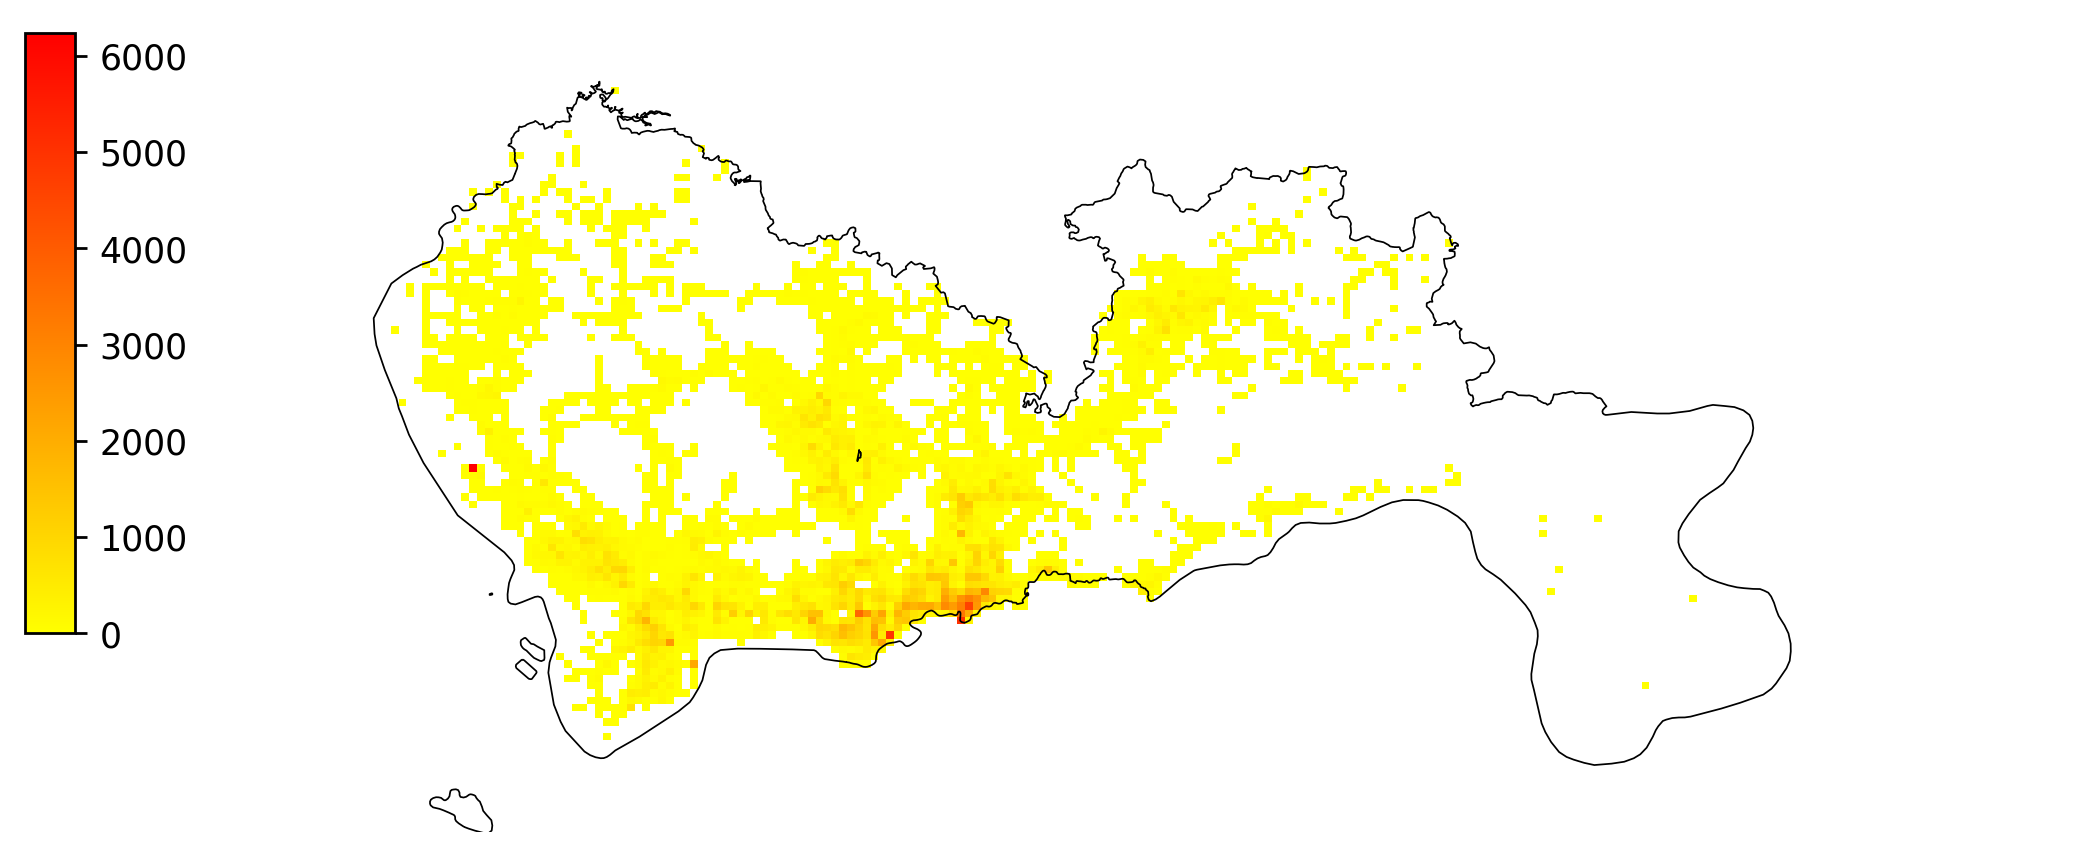

In [53]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#设置colormap的数据
import matplotlib
vmax = gridtoplot['count'].max()
#设定一个标准化的工具，设定OD的colormap最大最小值，他的作用是norm(count)就会将count标准化到0-1的范围内
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
#设定colormap的颜色
cmapname = 'autumn_r'
#cmap是一个获取颜色的工具，cmap(a)会返回颜色，其中a是0-1之间的值
cmap = matplotlib.cm.get_cmap(cmapname)


#将gridtoplot这个geodataframe进行绘制
#提示：用gridtoplot.plot，设定里面的参数是column = 'count'，以count这一列来绘制。参数cmap = cmap设定它的颜色
###########################你需要在下面写代码#############################
#gridtoplot.plot(...)

gridtoplot.plot(ax = ax,column = 'count',vmax = vmax, vmin = 0,cmap = cmap)
###################################################################################

#绘制整个深圳的范围
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)


#不显示坐标轴
plt.axis('off')    

#绘制假的colorbar，这是因为，我们画的OD是线，没办法直接画出来colorbar
#所以我们在一个看不见的地方画了一个叫imshow的东西，他的范围是0到vmax
#然后我们再对imshow添加colorbar
plt.imshow([[0,vmax]], cmap=cmap)
#设定colorbar的大小和位置
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)


#然后要把镜头调整回到深圳地图那，不然镜头就在imshow那里了


ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.show()

# 作业

上面绘制的是全部的OD，如何写个循环把每小时的OD都绘制图片然后保存下来？

（提示：用plt.title(图名)设置图名，用plt.savefig(路径)保存，每画完一张图以后记得plt.clf()清除画板）

# One more thing: 路网绘制

虽然上面的图已经很完美了，但是，即便是对深圳地图很熟悉的小旭学长，也看不出来上面的红色地方是在哪。

因此我们这一步要做的事情就是在图上加上路网

OpenStreetMap（简称OSM，中文是公开地图）是一个网上地图协作计划，目标是创造一个内容自由且能让所有人编辑的世界地图。
OSM是一款由网络大众共同打造的免费开源、可编辑的地图服务。OpenStreetMap它是利用公众集体的力量和无偿的贡献来改善地图相关的地理数据。OSM是非营利性的，它将数据回馈给社区重新用于其它的产品与服务。

我们可以从下面这个网址下载到OpenStreetMap的最新地图shp文件，每一两个星期它就会更新

<a href="http://download.geofabrik.de/asia.html">http://download.geofabrik.de/asia.html</a>

## 在geopandas上提取路网并绘制路网

好的经过我们上面的训练，地图处理应该不难了，现在我们的目标是：

    1.下载上面的地图底图
    2.用geopandas读取
    3.筛选出深圳地区的路网
    4.在上面画出的图上叠加一层，用浅色的细线条绘制（栅格的边就不要画出来了）

## 在Arcgis上出专题图

不过，光会geopandas是不够的，arcgis也是很重要的一个工具，所以试试将上面的画图操作全部用arcgis实现吧，需要实现的操作有：

    1.将合并的深圳行政区划导出为shp
    2.在arcgis中导入路网和行政区划
    3.在arcgis中筛选深圳范围的路网
    4.出专题图

提示：从python中算好的geopandas文件，geodataframe.to_file(路径,encoding = 'utf-8')可以导出为shapefile文件，arcgis可读